In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files
import zipfile
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time
from PIL import Image
from tempfile import TemporaryDirectory
from sklearn.metrics import classification_report, accuracy_score, f1_score

import warnings

In [3]:
cudnn.benchmark = True

plt.ion()

# filter warnings
warnings.filterwarnings('ignore')

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [5]:
data_dir = '/content/drive/My Drive/dataset/'

In [6]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, f'seg_{x}/seg_{x}'),
                                          data_transforms[x])
                  for x in ['train', 'test']}


In [7]:
train_size = int(0.8 * len(image_datasets['train']))  # 80% for train
val_size = len(image_datasets['train']) - train_size  # 20% for validation

train_dataset, val_dataset = random_split(image_datasets['train'], [train_size, val_size])

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}


In [8]:
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(image_datasets['test'])
}
class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

{'train': 11227, 'val': 2807, 'test': 3000}
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

				# save model
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0
                all_preds = []
                all_labels = []

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    if phase == 'val':
                        all_preds.extend(preds.cpu().numpy())
                        all_labels.extend(labels.cpu().numpy())

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                if phase == 'val':
                    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
                    epoch_accuracy = accuracy_score(all_labels, all_preds)
                    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_accuracy:.4f} F1: {epoch_f1:.4f}')

                    if epoch_accuracy > best_acc:
                        best_acc = epoch_accuracy
                        torch.save(model.state_dict(), best_model_params_path)
                else:
                    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best test Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model


In [11]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    unique_labels = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [13]:
model_conv = models.resnet18(weights='IMAGENET1K_V1')

for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 6)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=1e-03)

model_conv = model_conv.to(device)
model_conv = train_model(model_conv, criterion, optimizer_conv, lr_scheduler, num_epochs=5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 50.4MB/s]


Epoch 1/5
----------
train Loss: 0.6612 Acc: 0.7689
val Loss: 0.4222 Acc: 0.8525 F1: 0.8516
Epoch 2/5
----------
train Loss: 0.4637 Acc: 0.8301
val Loss: 0.3903 Acc: 0.8571 F1: 0.8567
Epoch 3/5
----------
train Loss: 0.4292 Acc: 0.8447
val Loss: 0.3867 Acc: 0.8621 F1: 0.8610
Epoch 4/5
----------
train Loss: 0.4146 Acc: 0.8472
val Loss: 0.3711 Acc: 0.8678 F1: 0.8676
Epoch 5/5
----------
train Loss: 0.4087 Acc: 0.8493
val Loss: 0.3912 Acc: 0.8575 F1: 0.8576

Training complete in 128m 25s
Best test Acc: 0.867830


In [14]:
# for test dataset
model_conv.eval()
all_preds = []
all_labels = []

for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model_conv(inputs)
        _, preds = torch.max(outputs, 1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())


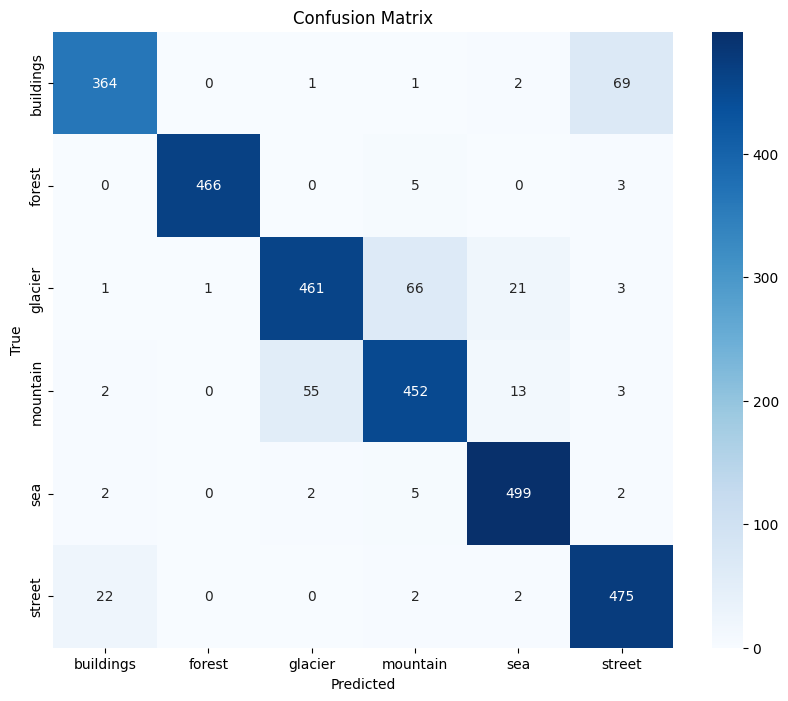

Accuracy: 0.9057
F1-score: 0.9052

Classification Report:

              precision    recall  f1-score   support

   buildings       0.93      0.83      0.88       437
      forest       1.00      0.98      0.99       474
     glacier       0.89      0.83      0.86       553
    mountain       0.85      0.86      0.86       525
         sea       0.93      0.98      0.95       510
      street       0.86      0.95      0.90       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



In [15]:
plot_confusion_matrix(all_labels, all_preds, class_names)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')  # 'weighted' class disbalance

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

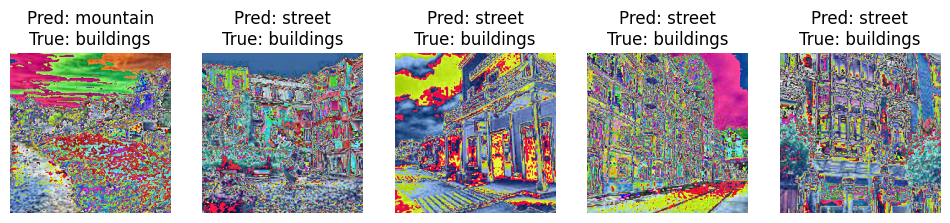

In [16]:
def visualize_incorrect_predictions(model, dataloader, class_names, num_images=5):
    model.eval()
    incorrect_preds = []
    true_labels = []
    images = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            incorrect_mask = preds != labels
            incorrect_preds.extend(preds[incorrect_mask].cpu().numpy())
            true_labels.extend(labels[incorrect_mask].cpu().numpy())
            images.extend(inputs[incorrect_mask].cpu())

            if len(incorrect_preds) >= num_images:
                break

    plt.figure(figsize=(12, 10))
    for i in range(min(num_images, len(incorrect_preds))):
        plt.subplot(1, num_images, i + 1)
        img = transforms.ToPILImage()(images[i])
        plt.imshow(img)
        plt.title(f'Pred: {class_names[incorrect_preds[i]]}\nTrue: {class_names[true_labels[i]]}')
        plt.axis('off')
    plt.show()

# Visualize Incorrect Predictions
visualize_incorrect_predictions(model_conv, dataloaders['test'], class_names)


### 1. **Навчання та продуктивність моделі**
   - Модель ResNet18 була обрана для задачі класифікації зображень із попередньо навченими вагами (ImageNet).
   - Початково всі шари ResNet18 були заморожені, окрім останнього шару (fully connected), який був адаптований для класифікації на 6 класів: **buildings**, **forest**, **glacier**, **mountain**, **sea**, **street**.
   - Для навчання використовувалася функція втрат `CrossEntropyLoss` та оптимізатор `Adam` з початковою швидкістю навчання 1e-03.
   - Протягом 5 епох навчання модель досягла найкращого результату з точністю на валідаційних даних **0.8678** (86.78%), що свідчить про гарну здатність до узагальнення на нових даних.

### 2. **Метрики на тестових даних**
   - На тестовій вибірці точність класифікації склала **0.9057** (90.57%), що є досить високим показником.
   - **F1-score**, що враховує як точність (precision), так і повноту (recall), також був високим і склав **0.9052** (90.52%).
   
   **Класифікаційний звіт**  показує наступні результати для кожного класу:
   - **buildings**: точність 0.93, F1-score 0.88, відмічаються деякі помилки класифікації, що свідчить про можливі труднощі в розпізнаванні цього класу.
   - **forest**: чудовий результат із точністю 1.00 та F1-score 0.99.
   - **glacier**: F1-score 0.86, що свідчить про певну складність моделі у правильній класифікації льодовиків, імовірно через схожість із іншими природними класами.
   - **mountain**: F1-score 0.86, модель також робила деякі помилки в розпізнаванні гірських ландшафтів.
   - **sea**: точність 0.93, F1-score 0.95, модель добре розпізнає цей клас.
   - **street**: точність 0.86, F1-score 0.90, помилки у класифікації, схожі з buildings, оскільки ці два класи можуть мати візуально схожі ознаки.

### 3. **Confusion matrix**
   - Модель продемонструвала деякі помилки при класифікації класу "buildings", що часто плуталися з "street" і навіть "mountain". Ці класи можуть мати схожі візуальні риси.
   - Класи "forest" і "sea" були класифіковані майже без помилок, що вказує на легкість для моделі в розпізнаванні цих середовищ.
   - Glacier були складнішими для класифікації, і модель робила помилки, плутаючи їх з mountain.

### 4. **Візуалізація неправильних передбачень**
   - Візуалізація неправильних передбачень моделі показує, що модель іноді плутає клас "buildings" з "street" і навіть "mountain". Це відображає складність для моделі в ідентифікації сцен, де можуть бути схожі елементи або контекст (наприклад, міські сцени можуть бути схожі на гірські через фон або певні особливості).
   - Ці візуалізації дозволяють зрозуміти, які саме зображення є важкими для моделі, що допомагає в подальшому вдосконаленні.

### 5. **Загальний висновок**
   Модель показує відмінні результати з точністю близько 90% та збалансованим F1-score на рівні 90%, що свідчить про хорошу продуктивність на різних класах даних. Високі значення точності та F1-score для більшості класів підтверджують, що ResNet18 може бути ефективним інструментом для задачі класифікації зображень в різних природних та міських середовищах.